In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras

In [6]:
data_dir = '/content/drive/MyDrive/audata/train'

In [7]:
data_d = '/content/drive/MyDrive/audata/train/Autistic'
lst = os.listdir(data_d) # your directory path
number_files = len(lst)
print(number_files)

1327


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

image_height = 256
batch_size=50

# Define image augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip the images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by up to 20%
    RandomZoom(0.2),  # Randomly zoom into the images by up to 20%
])

# Load Data with Augmentation
train_ds_init = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=3,
    image_size=(image_height, image_height),
    batch_size=batch_size
)
train_ds = train_ds_init.map(lambda x, y: (data_augmentation(x, training=True), y))  # Apply augmentation to training data

Found 2654 files belonging to 2 classes.
Using 2124 files for training.


In [9]:
class_names = train_ds_init.class_names
print(class_names)

['Autistic', 'Non_Autistic']


In [10]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=3,
    image_size=(image_height, image_height),
    batch_size=batch_size)

Found 2654 files belonging to 2 classes.
Using 530 files for validation.


In [12]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model, clone_model, Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.applications import ResNet50
from tensorflow.keras.layers import Activation, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model Architecture
resnet_model = Sequential()

pretrained_model = ResNet50(include_top=False,
                            input_shape=(256, 256, 3),
                            pooling='avg',
                            weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
resnet_model.add(BatchNormalization())  # Batch Normalization Layer
resnet_model.add(Dropout(0.5))  # Adding Dropout for Regularization
resnet_model.add(Dense(2, activation='sigmoid'))


# Compile Model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model with Early Stopping
epochs = 8
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]  # Include Early Stopping
)

Epoch 1/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 848s 19s/step - accuracy: 0.6727 - loss: 1.7009 - val_accuracy: 0.6642 - val_loss: 1.3941
Epoch 2/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 779s 18s/step - accuracy: 0.6997 - loss: 1.3903 - val_accuracy: 0.6887 - val_loss: 1.2369
Epoch 3/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 799s 18s/step - accuracy: 0.7333 - loss: 1.1828 - val_accuracy: 0.7245 - val_loss: 1.1138
Epoch 4/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 749s 17s/step - accuracy: 0.7388 - loss: 1.0873 - val_accuracy: 0.7377 - val_loss: 1.0539
Epoch 5/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 865s 19s/step - accuracy: 0.7454 - loss: 1.0296 - val_accuracy: 0.7170 - val_loss: 1.0021
Epoch 6/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 875s 19s/step - accuracy: 0.7461 - loss: 0.9635 - val_accuracy: 0.7434 - val_loss: 0.9456
Epoch 7/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 754s 18s/step - accuracy: 0.7565 - loss: 0.9087 - val_accuracy: 0.7226 - val_loss: 0.9193
Epoch 8/8
43/43 ━━━━━━━━━━━━━━━━━━━━ 737s 17s/step - accuracy: 0.7574 - loss: 0.8520 - val_accuracy: 0.7491 - v

In [ ]:
resnet_model.save('/content/drive/MyDrive/resnet_model3.h5')

Saving 011.jpg to 011.jpg


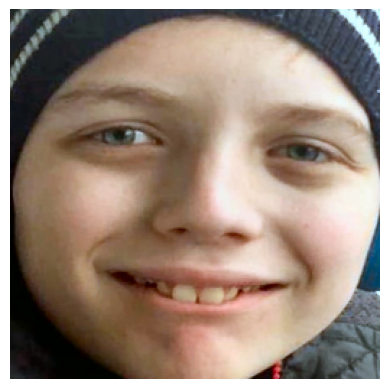

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Autistic


In [14]:
import cv2
from google.colab import files

def upload_and_predict_opencv(model, target_size=(256, 256)):
    # Upload an image file
    uploaded = files.upload()

    # Get the first (and only) file name
    file_name = list(uploaded.keys())[0]

    # Load the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, target_size)  # Resize the image to the target size

    # Preprocess the image
    img_array = np.expand_dims(img, axis=0)  # Expand dims to create batch
    img_array = img_array / 255.0  # Normalize the image to [0, 1]

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # No axes for the image
    plt.show()

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=-1)
    predicted_class_name = class_names[predicted_class_index[0]]

    print(f"Predicted class: {predicted_class_name}")


    return predicted_class_name


predicted_class = upload_and_predict_opencv(resnet_model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Precision: 0.74
Recall: 0.78
F1 Score: 0.76


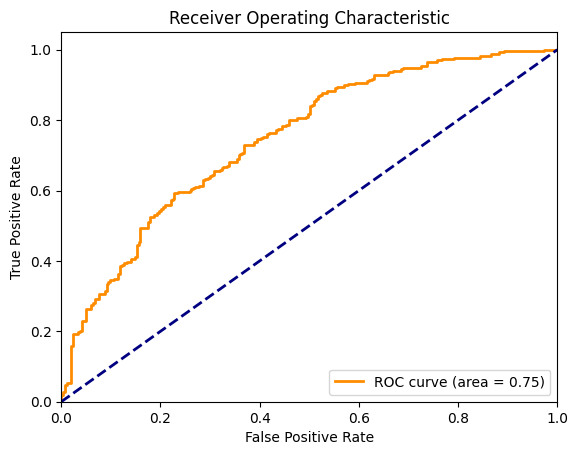

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

val_labels = []
val_probs = []
val_preds = []

# Iterate over the validation dataset
for images, labels in val_ds:
    preds = resnet_model.predict(images)
    val_probs.extend(preds[:, 1])  # Assuming that class 1 is the positive class
    val_labels.extend(labels.numpy())
    val_preds.extend(np.argmax(preds, axis=-1))  # Predicted classes

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()